with some reference to 
* https://www.kaggle.com/code/lingyixia/resnet18-base
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Setting Up

In [1]:
import copy
from datetime import datetime
import io
from matplotlib import pyplot as plt
import numpy as np
import os.path
import pandas as pd
from pdb import set_trace as st
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , models
from torch.optim import SGD

np.random.seed(21052) # ふlo五二
torch.manual_seed(21052)
device = 'cuda'
DATA_PATH = '../data/tfrecords-jpeg-512x512/' # can ignore the rest; they're all the same except resolution.
MODEL_WEIGHTS_PATH = './models/'


In [2]:
class FlowerDataset(Dataset):
    def __init__(self, images, classes, ids, transform, mode):
        self.images = images
        self.classes = classes
        self.ids = ids
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(io.BytesIO(self.images[idx]))
        img = self.transform(img)
        if self.mode == "test":
            idd = self.ids[idx]
            return (img, idd)
        else:
            label = self.classes[idx]
            return (img, label)
        
feats = {
    'train': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'val': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'test': {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
}

data_elems = {
    'train': {'ids': [], 'images': [], 'classes': []},
    'val': {'ids': [], 'images': [], 'classes': []},
    'test': {'ids': [], 'images': []}
}

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # https://pytorch.org/hub/pytorch_vision_resnet/
])

for dset_name in ['train', 'val', 'test']:
    dataset_path = os.path.join(DATA_PATH, dset_name)
    data_list = map(lambda path: tf.data.TFRecordDataset(os.path.join(dataset_path, path)), os.listdir(dataset_path))
    for tl in data_list:
        for t in tl.map(lambda x: tf.io.parse_single_example(x, feats[dset_name])):
            data_elems[dset_name]['ids'].append(str(t["id"].numpy())[2:-1])
            data_elems[dset_name]['images'].append(t["image"].numpy())
            if dset_name != 'test':
                data_elems[dset_name]['classes'].append(t["class"].numpy())

train_ds = FlowerDataset(data_elems['train']['images'], data_elems['train']['classes'], None, transform, 'train')
val_ds = FlowerDataset(data_elems['val']['images'], data_elems['val']['classes'], None, transform, 'val')
test_ds = FlowerDataset(data_elems['test']['images'], None, data_elems['test']['ids'], transform, 'test')

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
def train_model(model, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

## Sanity check (random guesses)

In [10]:
ys = []
y_preds = []

for x, y in val_dl:
    y_pred = torch.floor(torch.rand(y.shape) * 104)
    ys.append(y)
    y_preds.append(y_pred)

y = torch.cat(ys).cpu()
y_pred = torch.cat(y_preds).cpu()

f1 = f1_score(y, y_pred, average='macro')
print(f1)
acc = torch.sum(y == y_pred).item()
print(f'{acc}/{len(y)}')

0.005980498956210242
31/3712


## ResNet18 with initialization

In [2]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet18 = resnet18.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 09:54:15.898017==========
Training loss was 0.07108781486749649
Validated with f1=0.01715193609484355 and acc=769/3712
Epoch 1/25 at 2022-12-14 09:59:06.893883==========
Training loss was 0.06968242675065994
Validated with f1=0.018366165085456004 and acc=785/3712
Epoch 2/25 at 2022-12-14 10:02:42.126226==========
Training loss was 0.06929579377174377
Validated with f1=0.028497752615533743 and acc=1010/3712
Epoch 3/25 at 2022-12-14 10:06:12.656285==========
Training loss was 0.06852374225854874
Validated with f1=0.030221164755278015 and acc=1052/3712
Epoch 4/25 at 2022-12-14 10:09:38.622202==========
Training loss was 0.06804725527763367
Validated with f1=0.03904721333669788 and acc=1172/3712
Epoch 5/25 at 2022-12-14 10:13:10.095300==========
Training loss was 0.06759592145681381
Validated with f1=0.05569762469499757 and acc=1317/3712
Epoch 6/25 at 2022-12-14 10:16:42.464832==========
Training loss was 0.06709662824869156
Validated with f1=0.05953120629234698 an

Exception ignored in: <function UniquePtr.__del__ at 0x0000020C12EFB1C0>
Traceback (most recent call last):
  File "C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 15:58:45.127569==========
Training loss was 0.06051061674952507
Validated with f1=0.3752191957160929 and acc=2507/3712
Epoch 1/25 at 2022-12-14 16:01:04.258622==========
Training loss was 0.06048086658120155
Validated with f1=0.3759285567168699 and acc=2500/3712
Epoch 2/25 at 2022-12-14 16:04:30.306462==========
Training loss was 0.06045164540410042
Validated with f1=0.37581677727931273 and acc=2510/3712
Epoch 3/25 at 2022-12-14 16:07:33.003003==========
Training loss was 0.06044040620326996
Validated with f1=0.37548295061853476 and acc=2506/3712
Epoch 4/25 at 2022-12-14 16:10:26.734002==========
Training loss was 0.06044003739953041
Validated with f1=0.37438379498297675 and acc=2502/3712
Epoch 5/25 at 2022-12-14 16:13:57.465240==========
Training loss was 0.06042325496673584
Validated with f1=0.37521647683262493 and acc=2507/3712
Epoch 6/25 at 2022-12-14 16:17:02.536331==========
Training loss was 0.060423050075769424
Validated with f1=0.37490131245832736 and 

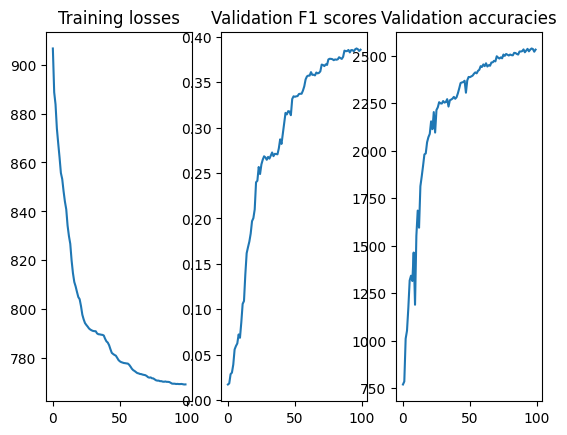

In [12]:

plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [19]:
torch.save(resnet18.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet18'))

## ResNet101 with transfer learning

In [2]:
def train_model2(model, params, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params, lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

In [10]:
resnet101 = models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.requires_grad = False

resnet101.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=104, bias=True),
    nn.Softmax(dim=1)
)

resnet101 = resnet101.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model2(resnet101, resnet101.fc.parameters(), epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 20:41:07.214005==========
Training loss was 0.07192531228065491
Validated with f1=0.003396409300251861 and acc=358/3712
Epoch 1/25 at 2022-12-14 20:44:15.601048==========
Training loss was 0.07138335704803467
Validated with f1=0.0071231658092346115 and acc=520/3712
Epoch 2/25 at 2022-12-14 20:47:14.862051==========
Training loss was 0.0709356889128685
Validated with f1=0.007384253569507683 and acc=540/3712
Epoch 3/25 at 2022-12-14 20:50:10.596049==========
Training loss was 0.07087762653827667
Validated with f1=0.00720249402373524 and acc=539/3712
Epoch 4/25 at 2022-12-14 20:53:10.527009==========
Training loss was 0.0707007423043251
Validated with f1=0.012274047956404079 and acc=662/3712
Epoch 5/25 at 2022-12-14 20:56:05.712050==========
Training loss was 0.0703384280204773
Validated with f1=0.012019645835728019 and acc=678/3712
Epoch 6/25 at 2022-12-14 20:59:01.720048==========
Training loss was 0.07027822732925415
Validated with f1=0.012091734108055235 and a

In [13]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model2(resnet101, resnet101.fc.parameters(), epochs=25, lr=0.001)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 23:45:17.926836==========
Training loss was 0.07011760026216507
Validated with f1=0.012083641301468403 and acc=690/3712
Epoch 1/25 at 2022-12-14 23:48:24.423946==========
Training loss was 0.07012419402599335
Validated with f1=0.01198507616051599 and acc=691/3712
Epoch 2/25 at 2022-12-14 23:51:31.657002==========
Training loss was 0.0701301246881485
Validated with f1=0.012058632743262632 and acc=690/3712
Epoch 3/25 at 2022-12-14 23:54:39.166526==========
Training loss was 0.0701289176940918
Validated with f1=0.012073420142409731 and acc=688/3712
Epoch 4/25 at 2022-12-14 23:58:01.731528==========
Training loss was 0.07013582438230515
Validated with f1=0.01210288951732851 and acc=688/3712
Epoch 5/25 at 2022-12-15 00:01:17.478309==========
Training loss was 0.07012587040662766
Validated with f1=0.012160701794794969 and acc=689/3712
Epoch 6/25 at 2022-12-15 00:04:29.061848==========
Training loss was 0.07011736184358597
Validated with f1=0.012093008887061812 and ac

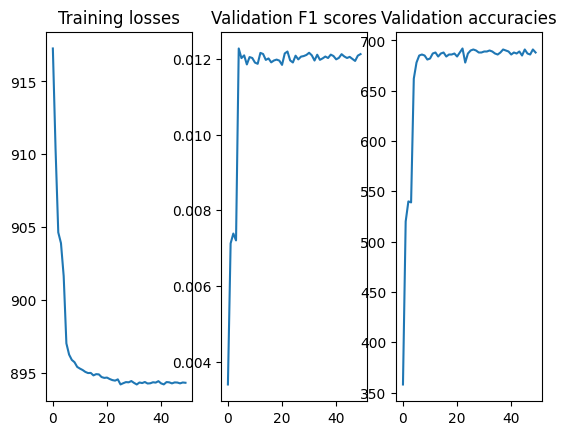

In [14]:
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [ ]:
torch.save(resnet101.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet101'))

## ResNet34 with initialization

In [3]:
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet34 = resnet34.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-15 23:41:50.275734==========
Training loss was 0.07107633352279663
Validated with f1=0.013610830725752142 and acc=700/3712
Epoch 1/25 at 2022-12-15 23:45:34.313691==========
Training loss was 0.06933742761611938
Validated with f1=0.025037324521310137 and acc=982/3712
Epoch 2/25 at 2022-12-15 23:48:47.347825==========
Training loss was 0.06851490586996078
Validated with f1=0.031301650154246755 and acc=1096/3712
Epoch 3/25 at 2022-12-15 23:51:56.265302==========
Training loss was 0.06816298514604568
Validated with f1=0.03171114305570086 and acc=1120/3712
Epoch 4/25 at 2022-12-15 23:55:04.872346==========
Training loss was 0.0680440366268158
Validated with f1=0.0436261280835813 and acc=1182/3712
Epoch 5/25 at 2022-12-15 23:58:29.324746==========
Training loss was 0.06736338883638382
Validated with f1=0.07185051007855338 and acc=1397/3712
Epoch 6/25 at 2022-12-16 00:01:34.098639==========
Training loss was 0.06651289761066437
Validated with f1=0.08794403626829227 and 

In [5]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 01:03:18.198030==========
Training loss was 0.06152801215648651
Validated with f1=0.3160459152280313 and acc=2397/3712
Epoch 1/25 at 2022-12-16 01:06:32.100801==========
Training loss was 0.06140241026878357
Validated with f1=0.31688345036493526 and acc=2408/3712
Epoch 2/25 at 2022-12-16 01:09:44.577991==========
Training loss was 0.061361223459243774
Validated with f1=0.31499523978111904 and acc=2384/3712
Epoch 3/25 at 2022-12-16 01:12:53.878150==========
Training loss was 0.06132771447300911
Validated with f1=0.31761090098568145 and acc=2409/3712
Epoch 4/25 at 2022-12-16 01:16:03.689286==========
Training loss was 0.06127144768834114
Validated with f1=0.3266561701172654 and acc=2430/3712
Epoch 5/25 at 2022-12-16 01:19:17.995291==========
Training loss was 0.0612003318965435
Validated with f1=0.32734415405581846 and acc=2436/3712
Epoch 6/25 at 2022-12-16 01:22:30.526098==========
Training loss was 0.06118516996502876
Validated with f1=0.32308375890846963 and a

In [6]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 02:22:46.990678==========
Training loss was 0.06039073318243027
Validated with f1=0.3832442407063227 and acc=2532/3712
Epoch 1/25 at 2022-12-16 02:25:48.982918==========
Training loss was 0.06031084805727005
Validated with f1=0.3859040743509301 and acc=2561/3712
Epoch 2/25 at 2022-12-16 02:28:41.084872==========
Training loss was 0.060283269733190536
Validated with f1=0.38813178070938387 and acc=2556/3712
Epoch 3/25 at 2022-12-16 02:31:31.390920==========
Training loss was 0.06025124713778496
Validated with f1=0.38700079393076897 and acc=2547/3712
Epoch 4/25 at 2022-12-16 02:34:22.003880==========
Training loss was 0.060235653072595596
Validated with f1=0.38717592617690844 and acc=2551/3712
Epoch 5/25 at 2022-12-16 02:37:11.059921==========
Training loss was 0.06022569537162781
Validated with f1=0.38667346995102087 and acc=2545/3712
Epoch 6/25 at 2022-12-16 02:40:01.325920==========
Training loss was 0.06021701171994209
Validated with f1=0.38874637288519565 and

In [11]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-16 11:34:15.555720==========
Training loss was 0.059827983379364014
Validated with f1=0.41145384713517597 and acc=2591/3712
Epoch 1/25 at 2022-12-16 11:37:06.191000==========
Training loss was 0.05982416495680809
Validated with f1=0.4150780429102514 and acc=2607/3712
Epoch 2/25 at 2022-12-16 11:39:58.401562==========
Training loss was 0.05980255827307701
Validated with f1=0.4152868951069395 and acc=2608/3712
Epoch 3/25 at 2022-12-16 11:42:50.834555==========
Training loss was 0.05979490652680397
Validated with f1=0.41411560552046167 and acc=2600/3712
Epoch 4/25 at 2022-12-16 11:45:47.840499==========
Training loss was 0.059786465018987656
Validated with f1=0.41458397204745706 and acc=2605/3712
Epoch 5/25 at 2022-12-16 11:48:47.869685==========
Training loss was 0.05978158861398697
Validated with f1=0.41366877349660053 and acc=2607/3712
Epoch 6/25 at 2022-12-16 12:04:31.977619==========
Training loss was 0.05977664887905121
Validated with f1=0.41496215712927464 and

In [16]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet34, epochs=50, lr=0.005)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/50 at 2022-12-16 13:59:40.360099==========
Training loss was 0.05973279848694801
Validated with f1=0.41489225893892734 and acc=2629/3712
Epoch 1/50 at 2022-12-16 14:02:54.810940==========
Training loss was 0.0597246028482914
Validated with f1=0.4151655109051368 and acc=2630/3712
Epoch 2/50 at 2022-12-16 14:06:20.013638==========
Training loss was 0.05972586199641228
Validated with f1=0.41347927192863626 and acc=2621/3712
Epoch 3/50 at 2022-12-16 14:09:53.036032==========
Training loss was 0.059729352593421936
Validated with f1=0.414291121354904 and acc=2627/3712
Epoch 4/50 at 2022-12-16 14:13:28.990893==========
Training loss was 0.059715576469898224
Validated with f1=0.4159265817303593 and acc=2633/3712
Epoch 5/50 at 2022-12-16 14:16:59.161675==========
Training loss was 0.05971338227391243
Validated with f1=0.4131716989331161 and acc=2620/3712
Epoch 6/50 at 2022-12-16 14:20:25.574055==========
Training loss was 0.05970974639058113
Validated with f1=0.41647937852744116 and acc

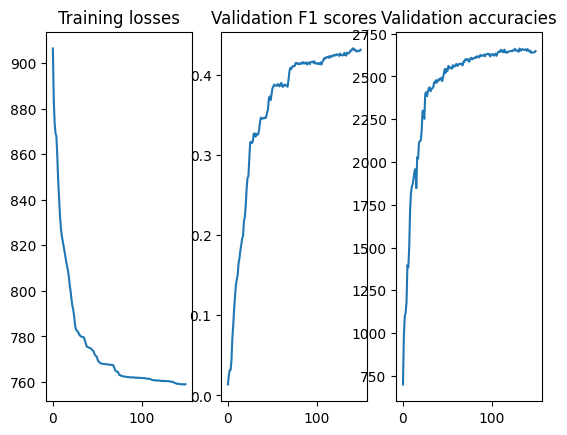

In [17]:
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [18]:
torch.save(resnet34.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34'))

## ResNet34 with initialization *and* weighted cross entropy


In [4]:
def train_model3(model, criterion, epochs=10, lr=0.0005, eval_every=1):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs


In [5]:
resnet34_w = models.resnet34(pretrained=True)
resnet34_w.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet34_w = resnet34_w.to(device)


C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class_weights = compute_class_weight('balanced', classes=list(set(data_elems['train']['classes'])), y=data_elems['train']['classes'])

In [7]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [8]:
losses = []
val_f1s = []
val_accs = []

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model3(resnet34_w, criterion, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run
torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model3(resnet34_w, criterion, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run
torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model3(resnet34_w, criterion, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run
torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

Epoch 0/25 at 2022-12-27 11:11:38.417028==========
Training loss was 0.07240965217351913
Validated with f1=0.02756977849182011 and acc=281/3712
Epoch 1/25 at 2022-12-27 11:15:32.737834==========
Training loss was 0.07085779309272766
Validated with f1=0.06981714232639476 and acc=511/3712
Epoch 2/25 at 2022-12-27 11:18:38.612268==========
Training loss was 0.06974264234304428
Validated with f1=0.08291916780637366 and acc=625/3712
Epoch 3/25 at 2022-12-27 11:21:52.087611==========
Training loss was 0.06898239254951477
Validated with f1=0.1221741501140512 and acc=695/3712
Epoch 4/25 at 2022-12-27 11:25:02.677719==========
Training loss was 0.06830517947673798
Validated with f1=0.124152111139563 and acc=522/3712
Epoch 5/25 at 2022-12-27 11:28:08.625719==========
Training loss was 0.06793674826622009
Validated with f1=0.16149720846704435 and acc=848/3712
Epoch 6/25 at 2022-12-27 11:31:25.577861==========
Training loss was 0.06717780232429504
Validated with f1=0.23360998021803409 and acc=1110

In [9]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model3(resnet34_w, criterion, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run
torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model3(resnet34_w, criterion, epochs=50, lr=0.005)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run
torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

Epoch 0/25 at 2022-12-27 17:23:44.654402==========
Training loss was 0.05873315408825874
Validated with f1=0.727793281452027 and acc=2724/3712
Epoch 1/25 at 2022-12-27 17:27:23.045297==========
Training loss was 0.058749761432409286
Validated with f1=0.7227918361942482 and acc=2725/3712
Epoch 2/25 at 2022-12-27 17:31:13.528494==========
Training loss was 0.05873999372124672
Validated with f1=0.7274486378050729 and acc=2726/3712
Epoch 3/25 at 2022-12-27 17:35:04.347255==========
Training loss was 0.058758337050676346
Validated with f1=0.7203135460358842 and acc=2710/3712
Epoch 4/25 at 2022-12-27 17:39:27.322695==========
Training loss was 0.05875290557742119
Validated with f1=0.72254654731794 and acc=2734/3712
Epoch 5/25 at 2022-12-27 17:43:43.081600==========
Training loss was 0.05873517319560051
Validated with f1=0.7212771371496364 and acc=2719/3712
Epoch 6/25 at 2022-12-27 17:48:21.228528==========
Training loss was 0.058726709336042404
Validated with f1=0.7244955967382929 and acc=27

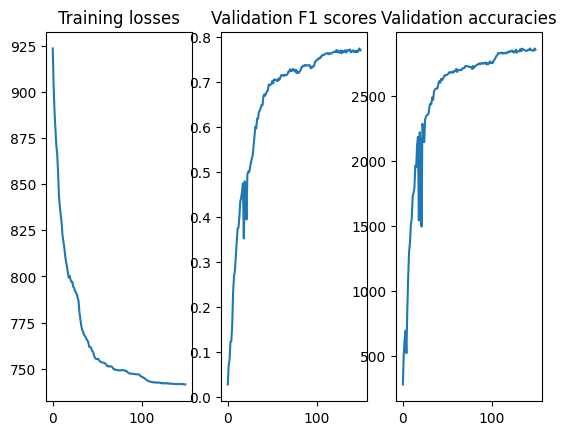

In [10]:

plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [11]:

torch.save(resnet34_w.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w'))

## Comparison of ResNet34 with and without class weights

Forgot to save the numeric outputs earlier, so I'm reverse engineering from the text output.

In [4]:
output_no_weights = '''Epoch 0/25 at 2022-12-15 23:41:50.275734==========
Training loss was 0.07107633352279663
Validated with f1=0.013610830725752142 and acc=700/3712
Epoch 1/25 at 2022-12-15 23:45:34.313691==========
Training loss was 0.06933742761611938
Validated with f1=0.025037324521310137 and acc=982/3712
Epoch 2/25 at 2022-12-15 23:48:47.347825==========
Training loss was 0.06851490586996078
Validated with f1=0.031301650154246755 and acc=1096/3712
Epoch 3/25 at 2022-12-15 23:51:56.265302==========
Training loss was 0.06816298514604568
Validated with f1=0.03171114305570086 and acc=1120/3712
Epoch 4/25 at 2022-12-15 23:55:04.872346==========
Training loss was 0.0680440366268158
Validated with f1=0.0436261280835813 and acc=1182/3712
Epoch 5/25 at 2022-12-15 23:58:29.324746==========
Training loss was 0.06736338883638382
Validated with f1=0.07185051007855338 and acc=1397/3712
Epoch 6/25 at 2022-12-16 00:01:34.098639==========
Training loss was 0.06651289761066437
Validated with f1=0.08794403626829227 and acc=1384/3712
Epoch 7/25 at 2022-12-16 00:04:50.233914==========
Training loss was 0.06593222916126251
Validated with f1=0.10850389584217542 and acc=1500/3712
Epoch 8/25 at 2022-12-16 00:08:01.031619==========
Training loss was 0.06533429771661758
Validated with f1=0.12369693880502003 and acc=1718/3712
Epoch 9/25 at 2022-12-16 00:11:32.020612==========
Training loss was 0.06488588452339172
Validated with f1=0.1380967536085531 and acc=1821/3712
Epoch 10/25 at 2022-12-16 00:15:15.109916==========
Training loss was 0.06463541090488434
Validated with f1=0.144977403513279 and acc=1855/3712
Epoch 11/25 at 2022-12-16 00:18:30.969070==========
Training loss was 0.06445867568254471
Validated with f1=0.1505329365534422 and acc=1872/3712
Epoch 12/25 at 2022-12-16 00:21:35.413056==========
Training loss was 0.0642959401011467
Validated with f1=0.16547358116952332 and acc=1908/3712
Epoch 13/25 at 2022-12-16 00:24:41.197692==========
Training loss was 0.06410106271505356
Validated with f1=0.1714383294597006 and acc=1946/3712
Epoch 14/25 at 2022-12-16 00:27:44.475925==========
Training loss was 0.06393317133188248
Validated with f1=0.18111322461225338 and acc=1958/3712
Epoch 15/25 at 2022-12-16 00:30:49.278004==========
Training loss was 0.06372303515672684
Validated with f1=0.1879047636361394 and acc=1847/3712
Epoch 16/25 at 2022-12-16 00:33:57.406492==========
Training loss was 0.06358260661363602
Validated with f1=0.19629020938497843 and acc=2029/3712
Epoch 17/25 at 2022-12-16 00:37:06.377486==========
Training loss was 0.06342381983995438
Validated with f1=0.19899350633798127 and acc=2019/3712
Epoch 18/25 at 2022-12-16 00:40:26.287722==========
Training loss was 0.06320494413375854
Validated with f1=0.2173375237039738 and acc=2113/3712
Epoch 19/25 at 2022-12-16 00:43:32.704931==========
Training loss was 0.06292044371366501
Validated with f1=0.22287125788697673 and acc=2121/3712
Epoch 20/25 at 2022-12-16 00:46:50.164853==========
Training loss was 0.06270859390497208
Validated with f1=0.23650649494499182 and acc=2125/3712
Epoch 21/25 at 2022-12-16 00:50:06.960672==========
Training loss was 0.06241920217871666
Validated with f1=0.2572985978571066 and acc=2184/3712
Epoch 22/25 at 2022-12-16 00:53:20.792979==========
Training loss was 0.06220947578549385
Validated with f1=0.2716885902537141 and acc=2298/3712
Epoch 23/25 at 2022-12-16 00:56:37.849852==========
Training loss was 0.06206229701638222
Validated with f1=0.27348051150284786 and acc=2300/3712
Epoch 24/25 at 2022-12-16 00:59:54.348089==========
Training loss was 0.061834610998630524
Validated with f1=0.296110303095964 and acc=2252/3712
Epoch 0/25 at 2022-12-16 01:03:18.198030==========
Training loss was 0.06152801215648651
Validated with f1=0.3160459152280313 and acc=2397/3712
Epoch 1/25 at 2022-12-16 01:06:32.100801==========
Training loss was 0.06140241026878357
Validated with f1=0.31688345036493526 and acc=2408/3712
Epoch 2/25 at 2022-12-16 01:09:44.577991==========
Training loss was 0.061361223459243774
Validated with f1=0.31499523978111904 and acc=2384/3712
Epoch 3/25 at 2022-12-16 01:12:53.878150==========
Training loss was 0.06132771447300911
Validated with f1=0.31761090098568145 and acc=2409/3712
Epoch 4/25 at 2022-12-16 01:16:03.689286==========
Training loss was 0.06127144768834114
Validated with f1=0.3266561701172654 and acc=2430/3712
Epoch 5/25 at 2022-12-16 01:19:17.995291==========
Training loss was 0.0612003318965435
Validated with f1=0.32734415405581846 and acc=2436/3712
Epoch 6/25 at 2022-12-16 01:22:30.526098==========
Training loss was 0.06118516996502876
Validated with f1=0.32308375890846963 and acc=2413/3712
Epoch 7/25 at 2022-12-16 01:25:39.658124==========
Training loss was 0.061155568808317184
Validated with f1=0.32673201298331883 and acc=2427/3712
Epoch 8/25 at 2022-12-16 01:28:47.596332==========
Training loss was 0.06113963946700096
Validated with f1=0.32544480482205596 and acc=2430/3712
Epoch 9/25 at 2022-12-16 01:31:57.924119==========
Training loss was 0.061143361032009125
Validated with f1=0.326091934997418 and acc=2436/3712
Epoch 10/25 at 2022-12-16 01:35:10.928415==========
Training loss was 0.06112196296453476
Validated with f1=0.3312702358032716 and acc=2465/3712
Epoch 11/25 at 2022-12-16 01:38:25.111457==========
Training loss was 0.06102672964334488
Validated with f1=0.3408962450564799 and acc=2461/3712
Epoch 12/25 at 2022-12-16 01:41:38.786422==========
Training loss was 0.06092408299446106
Validated with f1=0.3468860454859138 and acc=2478/3712
Epoch 13/25 at 2022-12-16 01:44:50.434458==========
Training loss was 0.060818132013082504
Validated with f1=0.3452286956541248 and acc=2464/3712
Epoch 14/25 at 2022-12-16 01:48:04.731511==========
Training loss was 0.06080078333616257
Validated with f1=0.34576677199645095 and acc=2471/3712
Epoch 15/25 at 2022-12-16 01:51:17.406205==========
Training loss was 0.06078256294131279
Validated with f1=0.3465606561091793 and acc=2483/3712
Epoch 16/25 at 2022-12-16 01:54:26.567266==========
Training loss was 0.060770805925130844
Validated with f1=0.34697696800269884 and acc=2478/3712
Epoch 17/25 at 2022-12-16 01:57:35.557465==========
Training loss was 0.06076260656118393
Validated with f1=0.3460995579221568 and acc=2487/3712
Epoch 18/25 at 2022-12-16 02:00:48.398325==========
Training loss was 0.060745012015104294
Validated with f1=0.3479023897965383 and acc=2491/3712
Epoch 19/25 at 2022-12-16 02:03:55.652629==========
Training loss was 0.06070071458816528
Validated with f1=0.3532280023236256 and acc=2472/3712
Epoch 20/25 at 2022-12-16 02:07:06.112490==========
Training loss was 0.06067543104290962
Validated with f1=0.357137231038101 and acc=2493/3712
Epoch 21/25 at 2022-12-16 02:10:18.388643==========
Training loss was 0.06063314154744148
Validated with f1=0.37079521802233095 and acc=2517/3712
Epoch 22/25 at 2022-12-16 02:13:27.072408==========
Training loss was 0.060537006705999374
Validated with f1=0.3734247701828959 and acc=2543/3712
Epoch 23/25 at 2022-12-16 02:16:30.676462==========
Training loss was 0.060499157756567
Validated with f1=0.36871489830794835 and acc=2520/3712
Epoch 24/25 at 2022-12-16 02:19:36.774666==========
Training loss was 0.06047899276018143
Validated with f1=0.3761429087945993 and acc=2544/3712
Epoch 0/25 at 2022-12-16 02:22:46.990678==========
Training loss was 0.06039073318243027
Validated with f1=0.3832442407063227 and acc=2532/3712
Epoch 1/25 at 2022-12-16 02:25:48.982918==========
Training loss was 0.06031084805727005
Validated with f1=0.3859040743509301 and acc=2561/3712
Epoch 2/25 at 2022-12-16 02:28:41.084872==========
Training loss was 0.060283269733190536
Validated with f1=0.38813178070938387 and acc=2556/3712
Epoch 3/25 at 2022-12-16 02:31:31.390920==========
Training loss was 0.06025124713778496
Validated with f1=0.38700079393076897 and acc=2547/3712
Epoch 4/25 at 2022-12-16 02:34:22.003880==========
Training loss was 0.060235653072595596
Validated with f1=0.38717592617690844 and acc=2551/3712
Epoch 5/25 at 2022-12-16 02:37:11.059921==========
Training loss was 0.06022569537162781
Validated with f1=0.38667346995102087 and acc=2545/3712
Epoch 6/25 at 2022-12-16 02:40:01.325920==========
Training loss was 0.06021701171994209
Validated with f1=0.38874637288519565 and acc=2565/3712
Epoch 7/25 at 2022-12-16 02:47:24.370742==========
Training loss was 0.06021473929286003
Validated with f1=0.38719327905505263 and acc=2557/3712
Epoch 8/25 at 2022-12-16 03:21:24.190897==========
Training loss was 0.060214754194021225
Validated with f1=0.38597035585576217 and acc=2557/3712
Epoch 9/25 at 2022-12-16 03:26:28.958775==========
Training loss was 0.060207441449165344
Validated with f1=0.3887945077923836 and acc=2566/3712
Epoch 10/25 at 2022-12-16 03:35:08.018586==========
Training loss was 0.06020243093371391
Validated with f1=0.3903900439347145 and acc=2573/3712
Epoch 11/25 at 2022-12-16 03:43:04.757983==========
Training loss was 0.060198601335287094
Validated with f1=0.38603322117797545 and acc=2561/3712
Epoch 12/25 at 2022-12-16 04:06:36.305563==========
Training loss was 0.06019815802574158
Validated with f1=0.3853948069534455 and acc=2565/3712
Epoch 13/25 at 2022-12-16 04:24:55.823302==========
Training loss was 0.060189686715602875
Validated with f1=0.38755250746028397 and acc=2573/3712
Epoch 14/25 at 2022-12-16 04:49:56.045791==========
Training loss was 0.06019440293312073
Validated with f1=0.3883182283665778 and acc=2572/3712
Epoch 15/25 at 2022-12-16 04:56:32.684037==========
Training loss was 0.06018118932843208
Validated with f1=0.3870063405971352 and acc=2575/3712
Epoch 16/25 at 2022-12-16 05:37:33.501508==========
Training loss was 0.06018109992146492
Validated with f1=0.3868897383403373 and acc=2572/3712
Epoch 17/25 at 2022-12-16 06:18:54.659345==========
Training loss was 0.06017648056149483
Validated with f1=0.38547908658053665 and acc=2564/3712
Epoch 18/25 at 2022-12-16 06:57:58.487319==========
Training loss was 0.06016635522246361
Validated with f1=0.3931507473911654 and acc=2587/3712
Epoch 19/25 at 2022-12-16 07:25:47.131240==========
Training loss was 0.06008918210864067
Validated with f1=0.4036772253903323 and acc=2585/3712
Epoch 20/25 at 2022-12-16 07:29:12.758269==========
Training loss was 0.059995561838150024
Validated with f1=0.4090843505257528 and acc=2600/3712
Epoch 21/25 at 2022-12-16 07:34:15.778461==========
Training loss was 0.059971947222948074
Validated with f1=0.40748500121494896 and acc=2595/3712
Epoch 22/25 at 2022-12-16 07:52:50.978601==========
Training loss was 0.05994783341884613
Validated with f1=0.4094034916044623 and acc=2601/3712
Epoch 23/25 at 2022-12-16 08:30:45.097714==========
Training loss was 0.05994424968957901
Validated with f1=0.41157831976088705 and acc=2600/3712
Epoch 24/25 at 2022-12-16 09:00:37.339195==========
Training loss was 0.059876348823308945
Validated with f1=0.4112121882200443 and acc=2586/3712
Epoch 0/25 at 2022-12-16 11:34:15.555720==========
Training loss was 0.059827983379364014
Validated with f1=0.41145384713517597 and acc=2591/3712
Epoch 1/25 at 2022-12-16 11:37:06.191000==========
Training loss was 0.05982416495680809
Validated with f1=0.4150780429102514 and acc=2607/3712
Epoch 2/25 at 2022-12-16 11:39:58.401562==========
Training loss was 0.05980255827307701
Validated with f1=0.4152868951069395 and acc=2608/3712
Epoch 3/25 at 2022-12-16 11:42:50.834555==========
Training loss was 0.05979490652680397
Validated with f1=0.41411560552046167 and acc=2600/3712
Epoch 4/25 at 2022-12-16 11:45:47.840499==========
Training loss was 0.059786465018987656
Validated with f1=0.41458397204745706 and acc=2605/3712
Epoch 5/25 at 2022-12-16 11:48:47.869685==========
Training loss was 0.05978158861398697
Validated with f1=0.41366877349660053 and acc=2607/3712
Epoch 6/25 at 2022-12-16 12:04:31.977619==========
Training loss was 0.05977664887905121
Validated with f1=0.41496215712927464 and acc=2611/3712
Epoch 7/25 at 2022-12-16 12:07:36.873627==========
Training loss was 0.059776149690151215
Validated with f1=0.41421082861210634 and acc=2608/3712
Epoch 8/25 at 2022-12-16 12:16:35.148430==========
Training loss was 0.05976775661110878
Validated with f1=0.41450721615421987 and acc=2616/3712
Epoch 9/25 at 2022-12-16 12:19:40.872429==========
Training loss was 0.059763576835393906
Validated with f1=0.41639427528283035 and acc=2618/3712
Epoch 10/25 at 2022-12-16 12:22:48.307517==========
Training loss was 0.059761323034763336
Validated with f1=0.41460334025910683 and acc=2611/3712
Epoch 11/25 at 2022-12-16 12:25:59.979537==========
Training loss was 0.05975814536213875
Validated with f1=0.4145041307979787 and acc=2613/3712
Epoch 12/25 at 2022-12-16 12:29:17.555872==========
Training loss was 0.05975288152694702
Validated with f1=0.41590897944791505 and acc=2626/3712
Epoch 13/25 at 2022-12-16 12:32:35.136942==========
Training loss was 0.05974990501999855
Validated with f1=0.41564608497192496 and acc=2621/3712
Epoch 14/25 at 2022-12-16 12:35:59.445007==========
Training loss was 0.05975612998008728
Validated with f1=0.41317774929137485 and acc=2620/3712
Epoch 15/25 at 2022-12-16 12:39:32.895021==========
Training loss was 0.05975543335080147
Validated with f1=0.415639687672712 and acc=2622/3712
Epoch 16/25 at 2022-12-16 12:42:50.790021==========
Training loss was 0.05974096804857254
Validated with f1=0.41584626756530774 and acc=2628/3712
Epoch 17/25 at 2022-12-16 12:46:32.349056==========
Training loss was 0.059748705476522446
Validated with f1=0.41376289721990217 and acc=2617/3712
Epoch 18/25 at 2022-12-16 12:50:17.878109==========
Training loss was 0.05973723158240318
Validated with f1=0.4163078026009195 and acc=2626/3712
Epoch 19/25 at 2022-12-16 12:54:02.466615==========
Training loss was 0.05973880738019943
Validated with f1=0.41657327172615294 and acc=2631/3712
Epoch 20/25 at 2022-12-16 12:57:20.403049==========
Training loss was 0.05974894016981125
Validated with f1=0.41696141179273905 and acc=2632/3712
Epoch 21/25 at 2022-12-16 13:00:34.577913==========
Training loss was 0.059734929352998734
Validated with f1=0.415544988257369 and acc=2628/3712
Epoch 22/25 at 2022-12-16 13:03:57.672361==========
Training loss was 0.0597299188375473
Validated with f1=0.4172879650056908 and acc=2632/3712
Epoch 23/25 at 2022-12-16 13:07:35.433147==========
Training loss was 0.05973522365093231
Validated with f1=0.4147672192863341 and acc=2616/3712
Epoch 24/25 at 2022-12-16 13:10:48.689480==========
Training loss was 0.05973413214087486
Validated with f1=0.4142528129655366 and acc=2626/3712
Epoch 0/50 at 2022-12-16 13:59:40.360099==========
Training loss was 0.05973279848694801
Validated with f1=0.41489225893892734 and acc=2629/3712
Epoch 1/50 at 2022-12-16 14:02:54.810940==========
Training loss was 0.0597246028482914
Validated with f1=0.4151655109051368 and acc=2630/3712
Epoch 2/50 at 2022-12-16 14:06:20.013638==========
Training loss was 0.05972586199641228
Validated with f1=0.41347927192863626 and acc=2621/3712
Epoch 3/50 at 2022-12-16 14:09:53.036032==========
Training loss was 0.059729352593421936
Validated with f1=0.414291121354904 and acc=2627/3712
Epoch 4/50 at 2022-12-16 14:13:28.990893==========
Training loss was 0.059715576469898224
Validated with f1=0.4159265817303593 and acc=2633/3712
Epoch 5/50 at 2022-12-16 14:16:59.161675==========
Training loss was 0.05971338227391243
Validated with f1=0.4131716989331161 and acc=2620/3712
Epoch 6/50 at 2022-12-16 14:20:25.574055==========
Training loss was 0.05970974639058113
Validated with f1=0.41647937852744116 and acc=2633/3712
Epoch 7/50 at 2022-12-16 14:23:50.693110==========
Training loss was 0.059711676090955734
Validated with f1=0.41791460119488266 and acc=2642/3712
Epoch 8/50 at 2022-12-16 14:27:27.443755==========
Training loss was 0.05970431864261627
Validated with f1=0.4209909535794046 and acc=2646/3712
Epoch 9/50 at 2022-12-16 14:30:48.717767==========
Training loss was 0.05969482287764549
Validated with f1=0.4204543807630632 and acc=2642/3712
Epoch 10/50 at 2022-12-16 14:34:01.101826==========
Training loss was 0.05968180671334267
Validated with f1=0.42210779909411145 and acc=2655/3712
Epoch 11/50 at 2022-12-16 14:37:22.544036==========
Training loss was 0.059674348682165146
Validated with f1=0.42219437545262883 and acc=2653/3712
Epoch 12/50 at 2022-12-16 14:40:34.242922==========
Training loss was 0.05966147407889366
Validated with f1=0.42272341588665835 and acc=2642/3712
Epoch 13/50 at 2022-12-16 14:43:44.095178==========
Training loss was 0.05965260788798332
Validated with f1=0.4218125981405039 and acc=2642/3712
Epoch 14/50 at 2022-12-16 14:46:57.254189==========
Training loss was 0.0596521720290184
Validated with f1=0.42375766660269076 and acc=2656/3712
Epoch 15/50 at 2022-12-16 14:50:10.761187==========
Training loss was 0.05964689329266548
Validated with f1=0.42191537136779983 and acc=2640/3712
Epoch 16/50 at 2022-12-16 14:53:21.006180==========
Training loss was 0.05965670943260193
Validated with f1=0.4238390310018154 and acc=2642/3712
Epoch 17/50 at 2022-12-16 14:56:40.721259==========
Training loss was 0.059641361236572266
Validated with f1=0.42428848512661904 and acc=2638/3712
Epoch 18/50 at 2022-12-16 15:00:03.484033==========
Training loss was 0.05964277684688568
Validated with f1=0.42363645785444076 and acc=2644/3712
Epoch 19/50 at 2022-12-16 15:03:34.266173==========
Training loss was 0.05964161828160286
Validated with f1=0.42544749525747805 and acc=2645/3712
Epoch 20/50 at 2022-12-16 15:06:51.985760==========
Training loss was 0.05964534729719162
Validated with f1=0.42477178356414247 and acc=2646/3712
Epoch 21/50 at 2022-12-16 15:10:10.411318==========
Training loss was 0.059630658477544785
Validated with f1=0.42461524672044837 and acc=2648/3712
Epoch 22/50 at 2022-12-16 15:13:37.831966==========
Training loss was 0.059629444032907486
Validated with f1=0.425969620138507 and acc=2649/3712
Epoch 23/50 at 2022-12-16 15:18:18.667913==========
Training loss was 0.05963830649852753
Validated with f1=0.42587480748222784 and acc=2648/3712
Epoch 24/50 at 2022-12-16 15:22:34.179308==========
Training loss was 0.05961991101503372
Validated with f1=0.4252819490115906 and acc=2653/3712
Epoch 25/50 at 2022-12-16 15:25:30.158355==========
Training loss was 0.0596340037882328
Validated with f1=0.42412549590127474 and acc=2652/3712
Epoch 26/50 at 2022-12-16 15:28:21.622306==========
Training loss was 0.05962470918893814
Validated with f1=0.4269972548143413 and acc=2661/3712
Epoch 27/50 at 2022-12-16 15:31:12.426305==========
Training loss was 0.059618331491947174
Validated with f1=0.4256677720486701 and acc=2651/3712
Epoch 28/50 at 2022-12-16 15:34:01.846305==========
Training loss was 0.05962509661912918
Validated with f1=0.4246181513395211 and acc=2649/3712
Epoch 29/50 at 2022-12-16 15:36:50.908305==========
Training loss was 0.05962373688817024
Validated with f1=0.4250254378336207 and acc=2651/3712
Epoch 30/50 at 2022-12-16 15:39:41.341305==========
Training loss was 0.05962319299578667
Validated with f1=0.4249091042862045 and acc=2644/3712
Epoch 31/50 at 2022-12-16 15:42:30.933305==========
Training loss was 0.059611108154058456
Validated with f1=0.4280178981224061 and acc=2663/3712
Epoch 32/50 at 2022-12-16 15:45:19.821311==========
Training loss was 0.05960926041007042
Validated with f1=0.4252848227290703 and acc=2651/3712
Epoch 33/50 at 2022-12-16 15:48:08.255307==========
Training loss was 0.059601590037345886
Validated with f1=0.4244199383684189 and acc=2652/3712
Epoch 34/50 at 2022-12-16 15:55:31.968910==========
Training loss was 0.059606924653053284
Validated with f1=0.428213069789587 and acc=2660/3712
Epoch 35/50 at 2022-12-16 16:10:59.208533==========
Training loss was 0.05958938971161842
Validated with f1=0.42764432927466073 and acc=2657/3712
Epoch 36/50 at 2022-12-16 16:27:12.943389==========
Training loss was 0.05957956239581108
Validated with f1=0.427298284250087 and acc=2654/3712
Epoch 37/50 at 2022-12-16 16:30:19.193678==========
Training loss was 0.05955924838781357
Validated with f1=0.4289060135385006 and acc=2656/3712
Epoch 38/50 at 2022-12-16 16:36:05.063753==========
Training loss was 0.05955275893211365
Validated with f1=0.4309494455223066 and acc=2658/3712
Epoch 39/50 at 2022-12-16 16:39:16.957750==========
Training loss was 0.059535231441259384
Validated with f1=0.43081859922485555 and acc=2649/3712
Epoch 40/50 at 2022-12-16 16:43:23.870546==========
Training loss was 0.05953090637922287
Validated with f1=0.4333364327093677 and acc=2659/3712
Epoch 41/50 at 2022-12-16 16:46:53.874425==========
Training loss was 0.059530604630708694
Validated with f1=0.4333357449590575 and acc=2653/3712
Epoch 42/50 at 2022-12-16 17:08:02.514373==========
Training loss was 0.059529706835746765
Validated with f1=0.43130324678015997 and acc=2645/3712
Epoch 43/50 at 2022-12-16 17:14:14.682598==========
Training loss was 0.05951528996229172
Validated with f1=0.43200064043037656 and acc=2650/3712
Epoch 44/50 at 2022-12-16 17:20:16.972220==========
Training loss was 0.059517428278923035
Validated with f1=0.4298710749251103 and acc=2638/3712
Epoch 45/50 at 2022-12-16 17:24:05.253438==========
Training loss was 0.05951002985239029
Validated with f1=0.42958179681042447 and acc=2638/3712
Epoch 46/50 at 2022-12-16 17:29:01.594997==========
Training loss was 0.05952086299657822
Validated with f1=0.43043718580921314 and acc=2640/3712
Epoch 47/50 at 2022-12-16 17:33:03.880429==========
Training loss was 0.05950768291950226
Validated with f1=0.43044902919115996 and acc=2641/3712
Epoch 48/50 at 2022-12-16 17:37:52.722009==========
Training loss was 0.059509020298719406
Validated with f1=0.4300085459188391 and acc=2641/3712
Epoch 49/50 at 2022-12-16 17:43:32.772235==========
Training loss was 0.05951766297221184
Validated with f1=0.4318222504927245 and acc=2648/3712'''

output_weights = '''Epoch 0/25 at 2022-12-27 11:11:38.417028==========
Training loss was 0.07240965217351913
Validated with f1=0.02756977849182011 and acc=281/3712
Epoch 1/25 at 2022-12-27 11:15:32.737834==========
Training loss was 0.07085779309272766
Validated with f1=0.06981714232639476 and acc=511/3712
Epoch 2/25 at 2022-12-27 11:18:38.612268==========
Training loss was 0.06974264234304428
Validated with f1=0.08291916780637366 and acc=625/3712
Epoch 3/25 at 2022-12-27 11:21:52.087611==========
Training loss was 0.06898239254951477
Validated with f1=0.1221741501140512 and acc=695/3712
Epoch 4/25 at 2022-12-27 11:25:02.677719==========
Training loss was 0.06830517947673798
Validated with f1=0.124152111139563 and acc=522/3712
Epoch 5/25 at 2022-12-27 11:28:08.625719==========
Training loss was 0.06793674826622009
Validated with f1=0.16149720846704435 and acc=848/3712
Epoch 6/25 at 2022-12-27 11:31:25.577861==========
Training loss was 0.06717780232429504
Validated with f1=0.23360998021803409 and acc=1110/3712
Epoch 7/25 at 2022-12-27 11:34:54.202759==========
Training loss was 0.06614979356527328
Validated with f1=0.2680531399084178 and acc=1300/3712
Epoch 8/25 at 2022-12-27 11:38:07.189157==========
Training loss was 0.06568814814090729
Validated with f1=0.2806528983262509 and acc=1373/3712
Epoch 9/25 at 2022-12-27 11:41:18.655380==========
Training loss was 0.06533261388540268
Validated with f1=0.31168600017374604 and acc=1510/3712
Epoch 10/25 at 2022-12-27 11:44:35.377697==========
Training loss was 0.06499642878770828
Validated with f1=0.3397725857608159 and acc=1556/3712
Epoch 11/25 at 2022-12-27 11:47:49.512906==========
Training loss was 0.06447579711675644
Validated with f1=0.3743640842972006 and acc=1726/3712
Epoch 12/25 at 2022-12-27 11:50:57.107761==========
Training loss was 0.06422416865825653
Validated with f1=0.37646050663083364 and acc=1754/3712
Epoch 13/25 at 2022-12-27 11:54:07.728771==========
Training loss was 0.0639461874961853
Validated with f1=0.39986965382350703 and acc=1794/3712
Epoch 14/25 at 2022-12-27 11:57:28.504957==========
Training loss was 0.0635993555188179
Validated with f1=0.43450126784589294 and acc=1965/3712
Epoch 15/25 at 2022-12-27 12:00:29.742029==========
Training loss was 0.06334242224693298
Validated with f1=0.4426249370002039 and acc=1956/3712
Epoch 16/25 at 2022-12-27 12:03:31.467028==========
Training loss was 0.06316818296909332
Validated with f1=0.45664157850118364 and acc=2121/3712
Epoch 17/25 at 2022-12-27 12:06:34.583579==========
Training loss was 0.06287652999162674
Validated with f1=0.4750529443681749 and acc=2187/3712
Epoch 18/25 at 2022-12-27 12:11:39.855754==========
Training loss was 0.06267751753330231
Validated with f1=0.35246454395120774 and acc=1544/3712
Epoch 19/25 at 2022-12-27 12:15:01.026398==========
Training loss was 0.06275869160890579
Validated with f1=0.4798263020486726 and acc=2223/3712
Epoch 20/25 at 2022-12-27 12:18:11.434397==========
Training loss was 0.06259942054748535
Validated with f1=0.47427914947292776 and acc=2126/3712
Epoch 21/25 at 2022-12-27 12:21:16.872403==========
Training loss was 0.06249091774225235
Validated with f1=0.39461221750167724 and acc=1497/3712
Epoch 22/25 at 2022-12-27 12:24:20.326358==========
Training loss was 0.06250756978988647
Validated with f1=0.49477908247161395 and acc=2288/3712
Epoch 23/25 at 2022-12-27 12:27:22.615401==========
Training loss was 0.062294501811265945
Validated with f1=0.5014037264664231 and acc=2245/3712
Epoch 24/25 at 2022-12-27 12:30:26.560369==========
Training loss was 0.06224547699093819
Validated with f1=0.4998020899440319 and acc=2147/3712
Epoch 0/25 at 2022-12-27 12:33:30.257720==========
Training loss was 0.06212181970477104
Validated with f1=0.5092234730434936 and acc=2320/3712
Epoch 1/25 at 2022-12-27 12:54:42.270327==========
Training loss was 0.06204301491379738
Validated with f1=0.5215673894982853 and acc=2345/3712
Epoch 2/25 at 2022-12-27 13:18:07.732755==========
Training loss was 0.06197511404752731
Validated with f1=0.530093834290333 and acc=2355/3712
Epoch 3/25 at 2022-12-27 13:27:04.853092==========
Training loss was 0.06182383373379707
Validated with f1=0.5376154363111693 and acc=2357/3712
Epoch 4/25 at 2022-12-27 13:30:21.547063==========
Training loss was 0.06168621778488159
Validated with f1=0.5574900228154729 and acc=2371/3712
Epoch 5/25 at 2022-12-27 13:33:46.420298==========
Training loss was 0.0612078420817852
Validated with f1=0.5796431274361508 and acc=2425/3712
Epoch 6/25 at 2022-12-27 13:37:17.403969==========
Training loss was 0.0609133318066597
Validated with f1=0.601449135955574 and acc=2444/3712
Epoch 7/25 at 2022-12-27 13:40:36.470552==========
Training loss was 0.06064945086836815
Validated with f1=0.5972539097748176 and acc=2439/3712
Epoch 8/25 at 2022-12-27 13:43:52.338238==========
Training loss was 0.06047187000513077
Validated with f1=0.6194240406666327 and acc=2491/3712
Epoch 9/25 at 2022-12-27 13:47:08.169189==========
Training loss was 0.06039026379585266
Validated with f1=0.6191139352084333 and acc=2472/3712
Epoch 10/25 at 2022-12-27 13:50:53.279494==========
Training loss was 0.06026610732078552
Validated with f1=0.6339669906797943 and acc=2536/3712
Epoch 11/25 at 2022-12-27 13:54:44.261601==========
Training loss was 0.06020437180995941
Validated with f1=0.6370097449443712 and acc=2552/3712
Epoch 12/25 at 2022-12-27 13:58:18.129017==========
Training loss was 0.060156840831041336
Validated with f1=0.6428734551356966 and acc=2559/3712
Epoch 13/25 at 2022-12-27 14:01:42.480077==========
Training loss was 0.06006665900349617
Validated with f1=0.6496476255157366 and acc=2559/3712
Epoch 14/25 at 2022-12-27 14:04:55.906584==========
Training loss was 0.06001045182347298
Validated with f1=0.6488883132967902 and acc=2562/3712
Epoch 15/25 at 2022-12-27 14:08:14.613863==========
Training loss was 0.05992061644792557
Validated with f1=0.6679415995100201 and acc=2600/3712
Epoch 16/25 at 2022-12-27 14:11:34.201864==========
Training loss was 0.05974451079964638
Validated with f1=0.6730141310016934 and acc=2617/3712
Epoch 17/25 at 2022-12-27 14:14:54.280867==========
Training loss was 0.05973256006836891
Validated with f1=0.6702168584210503 and acc=2604/3712
Epoch 18/25 at 2022-12-27 14:18:16.738871==========
Training loss was 0.059703562408685684
Validated with f1=0.6751756928952137 and acc=2634/3712
Epoch 19/25 at 2022-12-27 14:21:36.648910==========
Training loss was 0.05958685278892517
Validated with f1=0.6799894225272596 and acc=2624/3712
Epoch 20/25 at 2022-12-27 14:24:58.247016==========
Training loss was 0.05954938754439354
Validated with f1=0.6814792504728129 and acc=2634/3712
Epoch 21/25 at 2022-12-27 14:28:28.744725==========
Training loss was 0.05944192036986351
Validated with f1=0.6949728374729429 and acc=2649/3712
Epoch 22/25 at 2022-12-27 14:31:53.383667==========
Training loss was 0.05931076034903526
Validated with f1=0.6934548910396935 and acc=2663/3712
Epoch 23/25 at 2022-12-27 14:35:16.816669==========
Training loss was 0.05924243852496147
Validated with f1=0.69415213119789 and acc=2660/3712
Epoch 24/25 at 2022-12-27 14:38:45.584644==========
Training loss was 0.05922786518931389
Validated with f1=0.6970360999434371 and acc=2664/3712
Epoch 0/25 at 2022-12-27 14:42:13.211859==========
Training loss was 0.05921906232833862
Validated with f1=0.7026090586220252 and acc=2667/3712
Epoch 1/25 at 2022-12-27 14:45:36.842693==========
Training loss was 0.05923239141702652
Validated with f1=0.6971914882647195 and acc=2673/3712
Epoch 2/25 at 2022-12-27 14:49:14.937719==========
Training loss was 0.05917570739984512
Validated with f1=0.7062458073402714 and acc=2685/3712
Epoch 3/25 at 2022-12-27 14:52:40.188718==========
Training loss was 0.05912298336625099
Validated with f1=0.7048614426120191 and acc=2680/3712
Epoch 4/25 at 2022-12-27 14:56:03.120719==========
Training loss was 0.05910709500312805
Validated with f1=0.705854737854408 and acc=2685/3712
Epoch 5/25 at 2022-12-27 14:59:27.106762==========
Training loss was 0.05908140912652016
Validated with f1=0.7032297570966641 and acc=2688/3712
Epoch 6/25 at 2022-12-27 15:02:51.274951==========
Training loss was 0.0590677373111248
Validated with f1=0.7025599075274792 and acc=2680/3712
Epoch 7/25 at 2022-12-27 15:06:14.170349==========
Training loss was 0.059071898460388184
Validated with f1=0.7081588650693876 and acc=2693/3712
Epoch 8/25 at 2022-12-27 15:09:32.441475==========
Training loss was 0.059057947248220444
Validated with f1=0.7054462333080038 and acc=2690/3712
Epoch 9/25 at 2022-12-27 15:12:57.228147==========
Training loss was 0.059031154960393906
Validated with f1=0.7104213635585387 and acc=2697/3712
Epoch 10/25 at 2022-12-27 15:16:17.328115==========
Training loss was 0.05899583548307419
Validated with f1=0.7157863223798986 and acc=2711/3712
Epoch 11/25 at 2022-12-27 15:19:38.453331==========
Training loss was 0.05893033742904663
Validated with f1=0.7154277255132636 and acc=2687/3712
Epoch 12/25 at 2022-12-27 15:22:40.861325==========
Training loss was 0.058936458081007004
Validated with f1=0.7159062507272214 and acc=2703/3712
Epoch 13/25 at 2022-12-27 15:25:43.244325==========
Training loss was 0.05890141800045967
Validated with f1=0.7138922412179903 and acc=2701/3712
Epoch 14/25 at 2022-12-27 15:28:42.631328==========
Training loss was 0.058912646025419235
Validated with f1=0.7169134821577282 and acc=2703/3712
Epoch 15/25 at 2022-12-27 15:59:29.780683==========
Training loss was 0.058916665613651276
Validated with f1=0.7161771970739076 and acc=2700/3712
Epoch 16/25 at 2022-12-27 16:44:31.589436==========
Training loss was 0.058909352868795395
Validated with f1=0.7158356942105435 and acc=2704/3712
Epoch 17/25 at 2022-12-27 16:58:02.925088==========
Training loss was 0.05887281894683838
Validated with f1=0.7181509050622493 and acc=2714/3712
Epoch 18/25 at 2022-12-27 17:01:04.619468==========
Training loss was 0.05881037190556526
Validated with f1=0.7234417888993645 and acc=2717/3712
Epoch 19/25 at 2022-12-27 17:04:13.040415==========
Training loss was 0.05879497900605202
Validated with f1=0.7231569119774579 and acc=2716/3712
Epoch 20/25 at 2022-12-27 17:07:21.703022==========
Training loss was 0.05876288563013077
Validated with f1=0.7286431468031707 and acc=2731/3712
Epoch 21/25 at 2022-12-27 17:10:37.708066==========
Training loss was 0.058772288262844086
Validated with f1=0.7250700880387908 and acc=2733/3712
Epoch 22/25 at 2022-12-27 17:13:52.731310==========
Training loss was 0.05875710770487785
Validated with f1=0.7253710126729662 and acc=2732/3712
Epoch 23/25 at 2022-12-27 17:17:07.087731==========
Training loss was 0.058752864599227905
Validated with f1=0.7298417072631894 and acc=2730/3712
Epoch 24/25 at 2022-12-27 17:20:24.606426==========
Training loss was 0.058747585862874985
Validated with f1=0.726084415267181 and acc=2730/3712
Epoch 0/25 at 2022-12-27 17:23:44.654402==========
Training loss was 0.05873315408825874
Validated with f1=0.727793281452027 and acc=2724/3712
Epoch 1/25 at 2022-12-27 17:27:23.045297==========
Training loss was 0.058749761432409286
Validated with f1=0.7227918361942482 and acc=2725/3712
Epoch 2/25 at 2022-12-27 17:31:13.528494==========
Training loss was 0.05873999372124672
Validated with f1=0.7274486378050729 and acc=2726/3712
Epoch 3/25 at 2022-12-27 17:35:04.347255==========
Training loss was 0.058758337050676346
Validated with f1=0.7203135460358842 and acc=2710/3712
Epoch 4/25 at 2022-12-27 17:39:27.322695==========
Training loss was 0.05875290557742119
Validated with f1=0.72254654731794 and acc=2734/3712
Epoch 5/25 at 2022-12-27 17:43:43.081600==========
Training loss was 0.05873517319560051
Validated with f1=0.7212771371496364 and acc=2719/3712
Epoch 6/25 at 2022-12-27 17:48:21.228528==========
Training loss was 0.058726709336042404
Validated with f1=0.7244955967382929 and acc=2729/3712
Epoch 7/25 at 2022-12-27 17:53:03.939607==========
Training loss was 0.058736130595207214
Validated with f1=0.7279630854211786 and acc=2735/3712
Epoch 8/25 at 2022-12-27 17:57:36.431752==========
Training loss was 0.058705270290374756
Validated with f1=0.734355974544774 and acc=2743/3712
Epoch 9/25 at 2022-12-27 18:01:55.366558==========
Training loss was 0.05866093933582306
Validated with f1=0.7346811223394336 and acc=2743/3712
Epoch 10/25 at 2022-12-27 18:08:00.848649==========
Training loss was 0.05863912031054497
Validated with f1=0.737310961339925 and acc=2749/3712
Epoch 11/25 at 2022-12-27 18:12:18.186193==========
Training loss was 0.0586230643093586
Validated with f1=0.7357410378796876 and acc=2754/3712
Epoch 12/25 at 2022-12-27 18:16:47.320022==========
Training loss was 0.05859445035457611
Validated with f1=0.7388883721624145 and acc=2747/3712
Epoch 13/25 at 2022-12-27 18:20:55.605745==========
Training loss was 0.05860529839992523
Validated with f1=0.7376808224366278 and acc=2753/3712
Epoch 14/25 at 2022-12-27 18:24:59.989925==========
Training loss was 0.058600425720214844
Validated with f1=0.736829132700842 and acc=2755/3712
Epoch 15/25 at 2022-12-27 18:29:03.553153==========
Training loss was 0.05859585106372833
Validated with f1=0.7379192204243942 and acc=2750/3712
Epoch 16/25 at 2022-12-27 18:33:12.773006==========
Training loss was 0.058586567640304565
Validated with f1=0.7381757394877133 and acc=2756/3712
Epoch 17/25 at 2022-12-27 18:37:21.644218==========
Training loss was 0.05858912691473961
Validated with f1=0.7380254236393596 and acc=2754/3712
Epoch 18/25 at 2022-12-27 18:41:30.637651==========
Training loss was 0.058575160801410675
Validated with f1=0.7316485815531409 and acc=2760/3712
Epoch 19/25 at 2022-12-27 18:45:44.996918==========
Training loss was 0.058570750057697296
Validated with f1=0.7313206752420671 and acc=2744/3712
Epoch 20/25 at 2022-12-27 18:49:55.196244==========
Training loss was 0.058571040630340576
Validated with f1=0.7351097315106435 and acc=2755/3712
Epoch 21/25 at 2022-12-27 18:54:02.903450==========
Training loss was 0.05857434868812561
Validated with f1=0.7346400008708629 and acc=2746/3712
Epoch 22/25 at 2022-12-27 18:58:15.064647==========
Training loss was 0.05856509134173393
Validated with f1=0.73685142777708 and acc=2758/3712
Epoch 23/25 at 2022-12-27 19:02:35.468507==========
Training loss was 0.058529626578092575
Validated with f1=0.7457089813814479 and acc=2769/3712
Epoch 24/25 at 2022-12-27 19:06:57.169968==========
Training loss was 0.058492518961429596
Validated with f1=0.7466391298906464 and acc=2754/3712
Epoch 0/50 at 2022-12-27 19:11:26.452243==========
Training loss was 0.05847373232245445
Validated with f1=0.7497534019453707 and acc=2759/3712
Epoch 1/50 at 2022-12-27 19:15:42.767509==========
Training loss was 0.0584566704928875
Validated with f1=0.7513956764170788 and acc=2756/3712
Epoch 2/50 at 2022-12-27 19:20:01.933301==========
Training loss was 0.05842683091759682
Validated with f1=0.7510216312623981 and acc=2774/3712
Epoch 3/50 at 2022-12-27 19:24:27.400347==========
Training loss was 0.05841347202658653
Validated with f1=0.7549007784783801 and acc=2782/3712
Epoch 4/50 at 2022-12-27 19:29:20.514195==========
Training loss was 0.05837644264101982
Validated with f1=0.7537994424269326 and acc=2795/3712
Epoch 5/50 at 2022-12-27 19:33:48.599660==========
Training loss was 0.0583471916615963
Validated with f1=0.7572230565175199 and acc=2810/3712
Epoch 6/50 at 2022-12-27 19:38:16.731538==========
Training loss was 0.0583188496530056
Validated with f1=0.7605105783405788 and acc=2815/3712
Epoch 7/50 at 2022-12-27 19:43:09.976693==========
Training loss was 0.05830720439553261
Validated with f1=0.7601810793578582 and acc=2833/3712
Epoch 8/50 at 2022-12-27 19:48:22.327312==========
Training loss was 0.058280520141124725
Validated with f1=0.7608082318300837 and acc=2831/3712
Epoch 9/50 at 2022-12-27 19:53:38.109810==========
Training loss was 0.05826214328408241
Validated with f1=0.7623056901224321 and acc=2831/3712
Epoch 10/50 at 2022-12-27 19:58:15.466128==========
Training loss was 0.05825953930616379
Validated with f1=0.7639658728234698 and acc=2834/3712
Epoch 11/50 at 2022-12-27 20:02:56.608908==========
Training loss was 0.05825132504105568
Validated with f1=0.7643397301562733 and acc=2837/3712
Epoch 12/50 at 2022-12-27 20:07:40.103758==========
Training loss was 0.058247312903404236
Validated with f1=0.7647226053946418 and acc=2828/3712
Epoch 13/50 at 2022-12-27 20:12:17.989290==========
Training loss was 0.05823294073343277
Validated with f1=0.7621614854883787 and acc=2832/3712
Epoch 14/50 at 2022-12-27 20:16:42.716652==========
Training loss was 0.05824114382266998
Validated with f1=0.7647412059052664 and acc=2833/3712
Epoch 15/50 at 2022-12-27 20:21:04.482822==========
Training loss was 0.05822154879570007
Validated with f1=0.7636065064621362 and acc=2830/3712
Epoch 16/50 at 2022-12-27 20:25:28.291658==========
Training loss was 0.058225128799676895
Validated with f1=0.7634884919529236 and acc=2837/3712
Epoch 17/50 at 2022-12-27 20:28:59.225344==========
Training loss was 0.05822654440999031
Validated with f1=0.7652441498019431 and acc=2832/3712
Epoch 18/50 at 2022-12-27 20:32:13.669408==========
Training loss was 0.058216460049152374
Validated with f1=0.7663414753316838 and acc=2838/3712
Epoch 19/50 at 2022-12-27 20:35:29.059867==========
Training loss was 0.058226071298122406
Validated with f1=0.7678847956468668 and acc=2846/3712
Epoch 20/50 at 2022-12-27 20:38:41.487897==========
Training loss was 0.05822465196251869
Validated with f1=0.7674477121798042 and acc=2840/3712
Epoch 21/50 at 2022-12-27 20:41:55.617173==========
Training loss was 0.05820140242576599
Validated with f1=0.7671048622277004 and acc=2845/3712
Epoch 22/50 at 2022-12-27 20:45:14.242256==========
Training loss was 0.05821467563509941
Validated with f1=0.7717208666885139 and acc=2851/3712
Epoch 23/50 at 2022-12-27 20:48:33.095097==========
Training loss was 0.05818716064095497
Validated with f1=0.7675416780652741 and acc=2843/3712
Epoch 24/50 at 2022-12-27 20:51:52.499104==========
Training loss was 0.05820209160447121
Validated with f1=0.7704783155951358 and acc=2847/3712
Epoch 25/50 at 2022-12-27 20:55:11.388152==========
Training loss was 0.0581909641623497
Validated with f1=0.7656965042609014 and acc=2836/3712
Epoch 26/50 at 2022-12-27 20:58:27.032921==========
Training loss was 0.05818808823823929
Validated with f1=0.7660817519583442 and acc=2845/3712
Epoch 27/50 at 2022-12-27 21:01:51.681320==========
Training loss was 0.05820339545607567
Validated with f1=0.7710157510552137 and acc=2859/3712
Epoch 28/50 at 2022-12-27 21:05:22.229327==========
Training loss was 0.058190103620290756
Validated with f1=0.7644027810760778 and acc=2835/3712
Epoch 29/50 at 2022-12-27 21:08:32.707813==========
Training loss was 0.05819780379533768
Validated with f1=0.7701175137061228 and acc=2848/3712
Epoch 30/50 at 2022-12-27 21:11:45.926499==========
Training loss was 0.05817630514502525
Validated with f1=0.766670327256992 and acc=2847/3712
Epoch 31/50 at 2022-12-27 21:14:55.777226==========
Training loss was 0.0581839457154274
Validated with f1=0.7683495086509223 and acc=2846/3712
Epoch 32/50 at 2022-12-27 21:20:32.160242==========
Training loss was 0.0581846758723259
Validated with f1=0.7713671860389243 and acc=2863/3712
Epoch 33/50 at 2022-12-27 21:23:55.019551==========
Training loss was 0.058167148381471634
Validated with f1=0.7661118808562575 and acc=2847/3712
Epoch 34/50 at 2022-12-27 21:27:20.140309==========
Training loss was 0.05817810446023941
Validated with f1=0.7714281016484128 and acc=2867/3712
Epoch 35/50 at 2022-12-27 21:30:41.503157==========
Training loss was 0.05817410722374916
Validated with f1=0.7707699814205727 and acc=2860/3712
Epoch 36/50 at 2022-12-27 21:34:02.433501==========
Training loss was 0.05816119536757469
Validated with f1=0.7709103354654924 and acc=2859/3712
Epoch 37/50 at 2022-12-27 21:37:21.644694==========
Training loss was 0.05816270783543587
Validated with f1=0.7729385145667049 and acc=2853/3712
Epoch 38/50 at 2022-12-27 21:40:41.853500==========
Training loss was 0.05816933885216713
Validated with f1=0.7673361628750969 and acc=2852/3712
Epoch 39/50 at 2022-12-27 21:44:05.281499==========
Training loss was 0.0581536591053009
Validated with f1=0.7670645544423884 and acc=2848/3712
Epoch 40/50 at 2022-12-27 21:47:26.865542==========
Training loss was 0.058159589767456055
Validated with f1=0.7702412957530202 and acc=2853/3712
Epoch 41/50 at 2022-12-27 21:50:58.404566==========
Training loss was 0.0581648014485836
Validated with f1=0.7708752796149908 and acc=2859/3712
Epoch 42/50 at 2022-12-27 21:54:29.802658==========
Training loss was 0.05816506966948509
Validated with f1=0.7670786336821892 and acc=2857/3712
Epoch 43/50 at 2022-12-27 21:58:17.430553==========
Training loss was 0.0581609345972538
Validated with f1=0.7690505246432269 and acc=2868/3712
Epoch 44/50 at 2022-12-27 22:01:39.087733==========
Training loss was 0.05815404653549194
Validated with f1=0.7669327712034808 and acc=2855/3712
Epoch 45/50 at 2022-12-27 22:04:54.813494==========
Training loss was 0.058156706392765045
Validated with f1=0.7706083893507868 and acc=2854/3712
Epoch 46/50 at 2022-12-27 22:08:11.385789==========
Training loss was 0.05817142501473427
Validated with f1=0.7671738461593756 and acc=2851/3712
Epoch 47/50 at 2022-12-27 22:11:25.755751==========
Training loss was 0.058148689568042755
Validated with f1=0.771982442369436 and acc=2851/3712
Epoch 48/50 at 2022-12-27 22:14:43.466719==========
Training loss was 0.05814302712678909
Validated with f1=0.7751591574139918 and acc=2868/3712
Epoch 49/50 at 2022-12-27 22:17:58.837901==========
Training loss was 0.05814818665385246
Validated with f1=0.7710382845112828 and acc=2859/3712'''

In [6]:
res_no_weights = [[], [], []]
res_weights = [[], [], []]

for line in output_no_weights.split('\n'):
    if 'Training' in line:
        res_no_weights[0].append(float(line[18:]))
    elif 'Validated' in line:
        res_no_weights[1].append(float(line[18:28]))
        res_no_weights[2].append(int(line.split('acc=')[1][:-5]))
        
for line in output_weights.split('\n'):
    if 'Training' in line:
        res_weights[0].append(float(line[18:]))
    elif 'Validated' in line:
        res_weights[1].append(float(line[18:28]))
        res_weights[2].append(int(line.split('acc=')[1][:-5]))

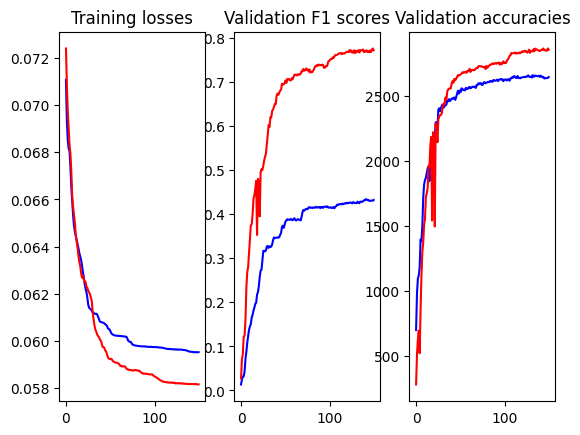

In [10]:
plt.subplot(1,3,1)
plt.plot(res_no_weights[0], 'b')
plt.plot(res_weights[0], 'r')
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(res_no_weights[1], 'b')
plt.plot(res_weights[1], 'r')
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(res_no_weights[2], 'b')
plt.plot(res_weights[2], 'r')
plt.title('Validation accuracies')
plt.show()

## Validating and Testing

In [3]:
model = models.resnet34(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS_PATH, 'resnet34_w')))

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
model.eval()

ys = []
y_preds = []

for x, y in val_dl:
    x = x.to(device)
    y = y.to(device)
    y_pred = torch.max(model(x), 1)[1]
    ys.append(y)
    y_preds.append(y_pred)

y = torch.cat(ys).cpu()
y_pred = torch.cat(y_preds).cpu()

f1 = f1_score(y, y_pred, average='macro')
acc = torch.sum(y == y_pred).item()
print(f'Validated with f1={f1} and acc={acc}/{len(y)} ({acc/len(y)*100}%)')

Validated with f1=0.7710382845112828 and acc=2859/3712 (77.02047413793103%)


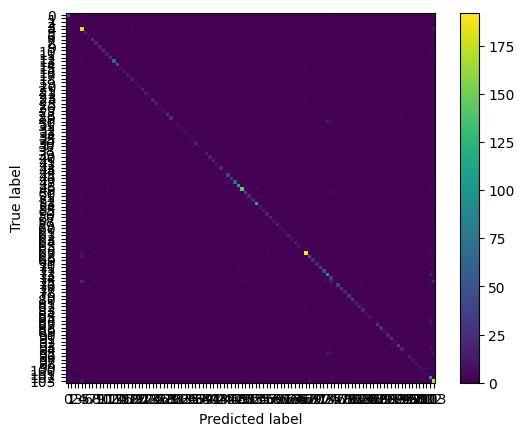

In [5]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, include_values=False)
plt.show()

In [6]:
model.eval()

inds = []
y_preds = []
for x, ind in test_dl:
    x = x.to(device)
    y_pred = torch.max(model(x), 1)[1]
    inds += ind
    y_preds.append(y_pred)

y_pred = torch.cat(y_preds).cpu()

In [7]:
with open('submission.csv', 'w') as f:
    f.write('id,label\n')
    for ind, yp in zip(inds, y_pred):
        f.write(f'{ind},{yp}\n')